In [22]:
# Importing Modules
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [23]:
# Defining transforms for both training and test data.
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [24]:
train_data = datasets.CIFAR10('data', train=True,download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
# Obtaining indices which can be useful for the vaidation of model.
num_train = len(train_data)
idx = list(range(num_train))
np.random.shuffle(idx)
split = int(np.floor(0.2 * num_train))
train_idx, valid_idx = idx[split:], idx[:split]

In [26]:
# defining sampler for batches.
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [27]:
batch_size = 20
# Creating loader instance to load data in batches.
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# classes 
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

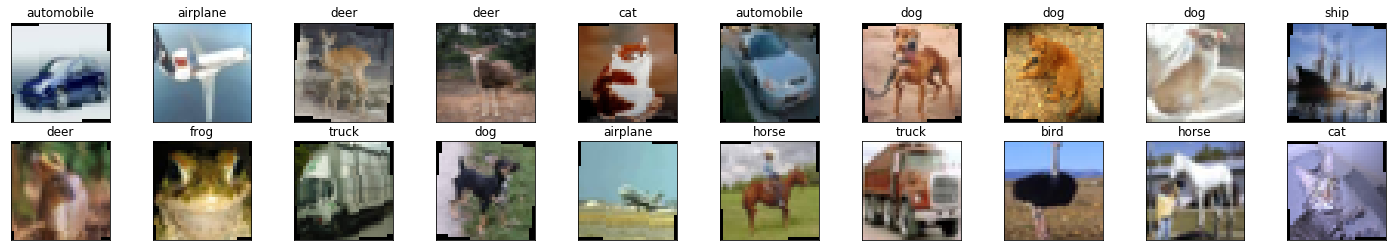

In [29]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))

# Let's display first batch.
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [30]:
# Defining Architecture
class Net(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        # convolutional layer (sees 32 x 32 x 3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        
        # convolutional layer (sees 16 x 16 x 16 image tensor)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        # convolutional layer (sees 8 x 8 x 32 image tensor)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # Hidden layer: 64 * 4 * 4 => 512.
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        
        # Hidden layer: 512 => 128.
        self.fc2 = nn.Linear(512, 128)
        
        # Hidden layer: 128 => 64.
        self.fc3 = nn.Linear(128, 64)
        
        # Hidden layer: 64 => 32.
        self.fc4 = nn.Linear(64, 32)
        
        # Hidden layer: 32 => 10.
        self.fc5 = nn.Linear(32, 10)
        
        # Defining dropout with p = 0.2
        self.droput = nn.Dropout(p=0.2)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
    def forward(self, X):
        
        # Convolutional Layer and  max pooling layers.
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        X = self.pool(F.relu(self.conv3(X)))
        
        X = self.droput(X)
        
        # Flatten inputs.
        X = X.view(-1, 64 * 4 * 4)
        # Passing through fully connected layers.
        X = self.droput(F.relu(self.fc1(X)))
        X = self.droput(F.relu(self.fc2(X)))
        X = self.droput(F.relu(self.fc3(X)))
        X = self.droput(F.relu(self.fc4(X)))
        
        X = self.fc5(X)
        
        return X

In [31]:
# Creating instance of Network. 
model = Net()

In [32]:
# Specify loss function.
criterion = nn.CrossEntropyLoss()

# Specify optimizer RMSProp => update of Adam.
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [0]:
epochs = 50
valid_loss_min = np.inf
for i in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    # Training the model.
    model.train()
    for images, labels in train_loader:
        
        # Clear the gradient for all optimized variables.
        optimizer.zero_grad()
        
        # Move images and lables to GPU if any avalible.
        images, labels = images.cuda(), labels.cuda()
        
        # forwardpass: passing images into model.
        output = model(images)
        
        # Calculating loss to perform the backward.
        loss = criterion(output, labels)
        
        # Backward pass compute the loss with respect to each parameters.
        loss.backward()
        
        # Single step of optimizer
        optimizer.step()
        
        # Updating total train loss.
        train_loss += loss.item()*images.size(0)
        
    # Setting model for evalution.
    model.eval()
    
    # Validating model.
    for images, labels in train_loader:
        
        # Move images and lables to GPU if any avalible.
        images, labels = images.cuda(), labels.cuda()
        
        # forwardpass: passing images into model.
        output = model(images)
        
        # Calculating loss to perform the backward.
        loss = criterion(output, labels)
        
        # Updating total validation loss.
        valid_loss += loss.item() * images.size(0)
        
    # Calculating training and validation loss.
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)
    
    print("Training Loss :", train_loss, "\t Validation Loss : ", valid_loss, "Epoch :", str(i + 1))
    if valid_loss <= valid_loss_min:
        print("Validation Loss is min. \t Saving model. \n")
        torch.save(model.state_dict(),'model_cifar_10.pth')
        valid_loss_min = valid_loss

Training Loss : 1.2951943230628968 	 Validation Loss :  1.1913781319856644 Epoch : 1
Validation Loss is min. 	 Saving model. 

Training Loss : 1.2400452795743941 	 Validation Loss :  1.129032593226433 Epoch : 2
Validation Loss is min. 	 Saving model. 

Training Loss : 1.1842843803405763 	 Validation Loss :  1.0607710835933686 Epoch : 3
Validation Loss is min. 	 Saving model. 

Training Loss : 1.129946898651123 	 Validation Loss :  1.0247085490226746 Epoch : 4
Validation Loss is min. 	 Saving model. 

Training Loss : 1.0840089642763138 	 Validation Loss :  0.9577322816371918 Epoch : 5
Validation Loss is min. 	 Saving model. 

Training Loss : 1.0381653262853623 	 Validation Loss :  0.9323525515556336 Epoch : 6
Validation Loss is min. 	 Saving model. 

Training Loss : 1.0004461144208907 	 Validation Loss :  0.896313558125496 Epoch : 7
Validation Loss is min. 	 Saving model. 

Training Loss : 0.966620023560524 	 Validation Loss :  0.8375467433571816 Epoch : 8
Validation Loss is min. 	 Savi

In [33]:
model.load_state_dict(torch.load('model_cifar_10.pth', map_location='cpu'))

In [35]:
device = "cpu"
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
  
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    
    # calculate the batch loss
    loss = criterion(output, target)
    
    # update test loss 
    test_loss += loss.item()*data.size(0)
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    
    if device == "gpu":
        correct = np.squeeze(correct_tensor.numpy())
    else:
        correct = np.squeeze(correct_tensor.cpu().numpy())
        
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[target.data[i]] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.665580

Test Accuracy of airplane: 81% (814/1000)
Test Accuracy of automobile: 89% (894/1000)
Test Accuracy of  bird: 67% (677/1000)
Test Accuracy of   cat: 59% (599/1000)
Test Accuracy of  deer: 77% (774/1000)
Test Accuracy of   dog: 68% (680/1000)
Test Accuracy of  frog: 88% (886/1000)
Test Accuracy of horse: 80% (803/1000)
Test Accuracy of  ship: 86% (868/1000)
Test Accuracy of truck: 83% (839/1000)

Test Accuracy (Overall): 78% (7834/10000)


In [36]:
dataiter = iter(test_loader)

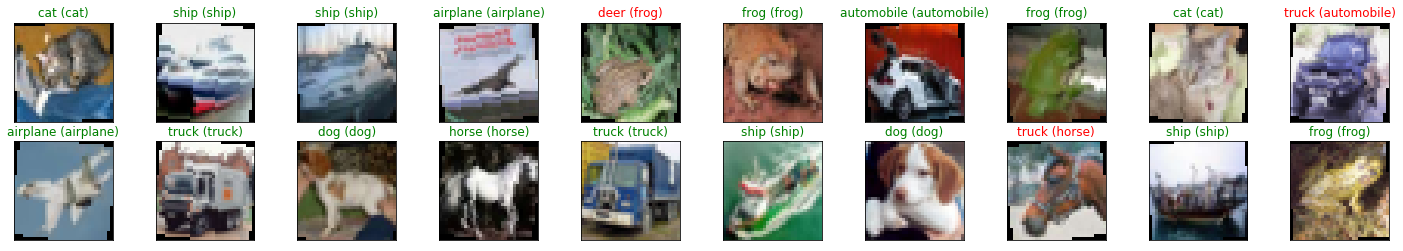

In [37]:
images, labels = dataiter.next()
images.numpy()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))